# Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

# Block 1 - Data exploration


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

car = glob.glob('vehicles/*/*.png')
notcar = glob.glob('non-vehicles/*/*.png')

"""
Provide some information about the datasets
"""
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    img = cv2.imread(car_list[0])
    data_dict["image_shape"] = img.shape
    data_dict["data_type"] = img.dtype
    return data_dict
    
data_info = data_look(car, notcar)

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


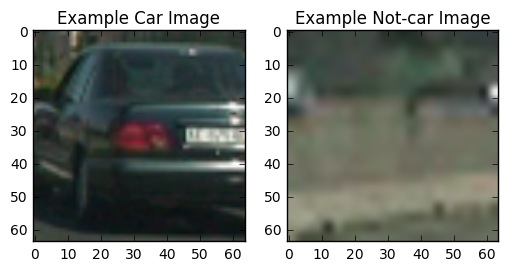

In [8]:
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car))
notcar_ind = np.random.randint(0, len(notcar))
    
# Read in car / not-car images
car_image = cv2.imread(car[car_ind])
notcar_image = cv2.imread(notcar[notcar_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)

car_image = car_image.astype(np.float32)/255.

#print(car_image[0])
#print(car_image.dtype)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Block 2 - Color and spatial bin features

First I tested the histogram on one image in the dataset and I discover that the dataset have color range from 0 ... 255 so,
in order to have a better classification, I have to normalize it and change the range in the hist from (0,256) -> (0.0, 1.0)

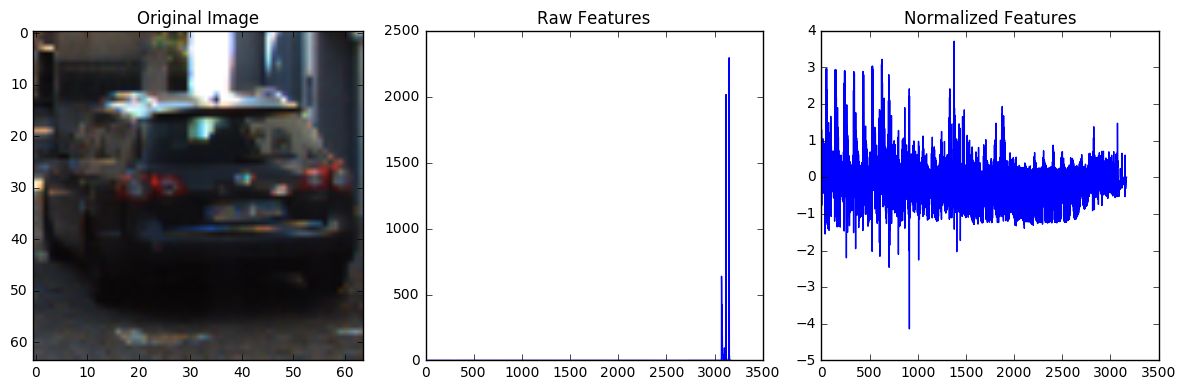

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import glob

"""
Compute binned color features
"""  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

"""
Compute color histogram features  
"""
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

"""
Apply color space conversion if required and extract the spacial and colored features
"""
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    features = []
    for img in imgs:
        image = cv2.imread(img)
        image = image.astype(np.float32)/255.
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            else: image
        spatial_features = bin_spatial(image, spatial_size)
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_features)))
    return features


car_features = extract_features(car, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0.0, 1.0))
notcar_features = extract_features(notcar, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0.0, 1.0))

"""
At this point we have to normalize our input in order to prevend that one type of feature preval to the other
in fact in the previous step we concatenate two types of features histogram and spatial bin
"""
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

0.51717
0.447776
(64, 64, 3)


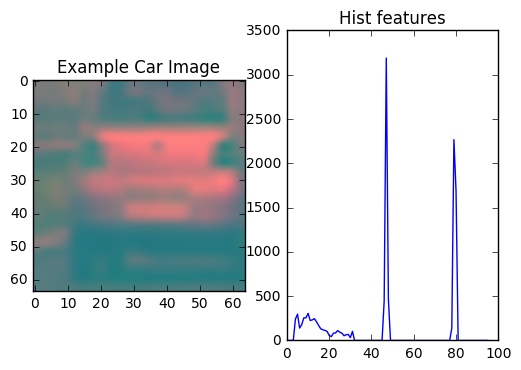

In [53]:
# Read in car / not-car images
car_image = cv2.imread(car[100])
car_image = car_image.astype(np.float32)/255.
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2YCrCb)

# Test hist
hist_features = color_hist(car_image, nbins=32, bins_range=(0.0, 1.0))

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.plot(hist_features)
plt.title('Hist features')

# Block 3 - HOG Features

I'll get some features with HOG technics to gather the more weighter direction of the gradient, based of the magneture, for each pixel

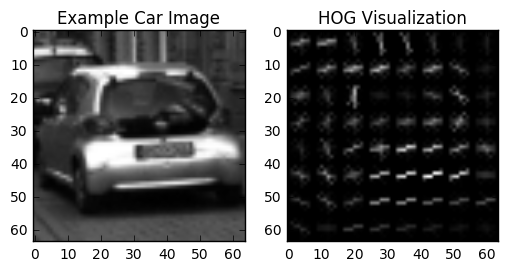

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import exposure
        
"""
Get the HOG features and hog_image
""" 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, gamma=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=vis, feature_vector=feature_vec, transform_sqrt = gamma)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=vis, feature_vector=feature_vec, transform_sqrt = gamma)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car))
# Read in the image
image = mpimg.imread(car[ind])
image = image.astype(np.float32)/255.
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False, gamma = True)
                        
#hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# TODO - Test an image with hog and color features

In [59]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car))
# Read in the image
image = cv2.imread(car[ind])
image = image.astype(np.float32)/255.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False, gamma = True)

"""
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(3, 3, 1), plt.imshow(draws[0]), plt.title('Test 1')
fig.add_subplot(3, 3, 2), plt.imshow(draws[1]), plt.title('Test 2')
fig.add_subplot(3, 3, 3), plt.imshow(draws[2]), plt.title('Test 3')
fig.add_subplot(3, 3, 4), plt.imshow(draws[3]), plt.title('Test 4')
fig.add_subplot(3, 3, 5), plt.imshow(draws[4]), plt.title('Test 5')
fig.add_subplot(3, 3, 6), plt.imshow(draws[5], cmap='gray'), plt.title('Test 6')
fig.tight_layout()
"""

plt.show()

# Block 4 - Combine HOG, color and spatial bin feautures

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

"""
Extract all features from image and return an array features
FEATURES:
    + HOG
    + BIN SPATIAL
    + COLOR 
"""
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0,256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, gamma = False):    
    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    for img in imgs:
        image = cv2.imread(img)
        image = image.astype(np.float32)/255.
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, gamma = gamma))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, gamma = gamma)
            #8) Append features to list
            img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    #9) Return concatenated array of features
    return img_features

### Test the features extraction

In [63]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0.0, 1.0)  # Range for a normalized img
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
gamma_correction = False

t=time.time()

car_features = extract_features(car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, gamma = gamma_correction)
notcar_features = extract_features(notcar, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, gamma=gamma_correction)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features from hog, spatial and color...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print(scaled_X.shape)

104.1 Seconds to extract features from hog, spatial and color...
(17760, 8460)


# Block 5 - Save result of the features extraction

Can be useful to save the result of features extraction for future usage

In [64]:
vehicle_dataset = {
    "car_feat" : car_features,
    "notcar_feat" : notcar_features
}

file_pi = open('vehicle_dataset.p', 'wb') 
pickle.dump(vehicle_dataset, file_pi)

# Block 6 - Linear SVM Classifier

For this task I used a Linear SVM for a good tradeoff from precision / time

In [65]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

"""
Scale the features
"""

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

"""
To prevent some ordering problem we're shuffling the dataset
"""
shu_X, shu_y = shuffle(scaled_X, y)

"""
Create train and test sets
"""
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    shu_X, shu_y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


### Save the trained classifier for future usage

In [67]:
classifier = {
    "classifier" : svc
}

file_pi = open('classifier.p', 'wb') 
pickle.dump(classifier, file_pi)

# Block 7 - Sliding windows

At this block I implemented some function to draw boxes and sliding function technics

For the sliding I choose to take only the bottom of the image because for sure the car are not in the sky :) <br>
About the size I choose the 96x96 because I can catch the better the right part of the image 

Numero di finestre = round(1280 / 96 * 2) * round(320 / 96 * 2)
50 % overlap = 2

125


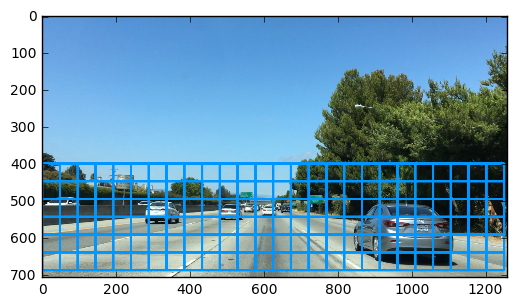

In [68]:
image = cv2.imread('bbox-example-image.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

"""
Draw boxes on the image
"""
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[0, image.shape[1]], y_start_stop=[400, image.shape[0]], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
                      
window_img = draw_boxes(image, windows, color=(0, 150, 255), thick=6)                    
plt.imshow(window_img)

# Block 8 - Car or not car ... this is the problem

8.27 Time to extract features...


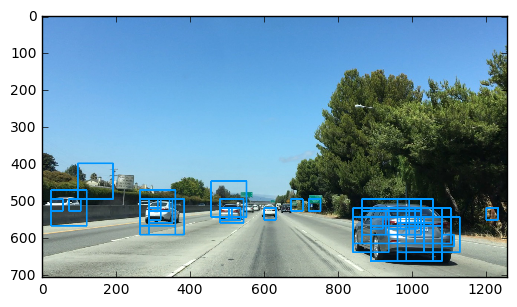

In [92]:
"""
Extract feature from a single image
"""

"""
Extract all features from image and return an array features
FEATURES:
    + HOG
    + BIN SPATIAL
    + COLOR 
"""
def extract_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0,256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, gamma = False):    

    image = image.astype(np.float32)/255.
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True, gamma = gamma))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True, gamma = gamma)

    #8) Return the features
    return np.concatenate((spatial_features, hist_features, hog_features))


"""
Though the windows detected search the car 
"""
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, gamma = False):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, gamma = gamma)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

"""
Pipeline on single image
"""

image = cv2.imread('bbox-example-image.jpg')

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0.0,1.0) #Normalize range
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
gamma_correction = False
x_start_stop=[0, image.shape[1]]
y_start_stop=[400, image.shape[0] - 40]

"""
Here I using the multi scale windows to improve detection of the far and near cars
"""

windows_far = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.50, 0.50))
windows_near = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows_small = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(32, 32), xy_overlap=(0.25, 0.25))
t=time.time()

hot_windows_far = search_windows(image, windows_far, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, gamma = gamma_correction) 
hot_windows_near = search_windows(image, windows_near, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, gamma = gamma_correction) 

hot_windows_small = search_windows(image, windows_small, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, gamma = gamma_correction) 
t2 = time.time()
print(round(t2-t, 2), 'Time to extract features...')

hot_windows = []
hot_windows.extend(hot_windows_far)
hot_windows.extend(hot_windows_near)
hot_windows.extend(hot_windows_small)

#For plot I'll convert in RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
window_img = draw_boxes(image, hot_windows, color=(0, 150, 255), thick=4)                    

plt.imshow(window_img)

# Block 9 - Hog sub sampling windows search

In the previous block we extract the features and predict car thought all windows but we can simple improve this task.<br>
The first step is to extract the features from the entire image and after we can sub-sample the features array in n-chunck and after predict the result on them.

1.04 Time to extract features...


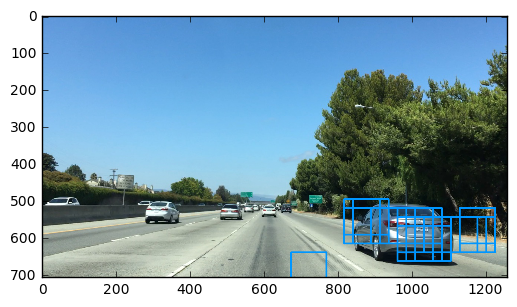

In [94]:
"""
Define a single function that can extract features using hog sub-sampling and make predictions
"""
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              hist_range=(0,256)):
    
    draw_img = np.copy(img)
    #Normalize features
    img = img.astype(np.float32)/255.
    # Take region of interest
    img_tosearch = img[ystart:ystop,:,:]
    # Change color space if required
    if color_space != 'BGR':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)      
    #ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,150,255),4) 
                
    return draw_img

"""
Pipeline on single image
"""

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0.0, 1.0)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
gamma_correction = False
x_start_stop=[0, image.shape[1]]
y_start_stop=[400, image.shape[0] - 40]


image = mpimg.imread('bbox-example-image.jpg')
    
ystart = 400
ystop = 680
scale = 1.5

t = time.time()
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Time to extract features...')

plt.imshow(out_img)

# Block 10 - Heatmap 

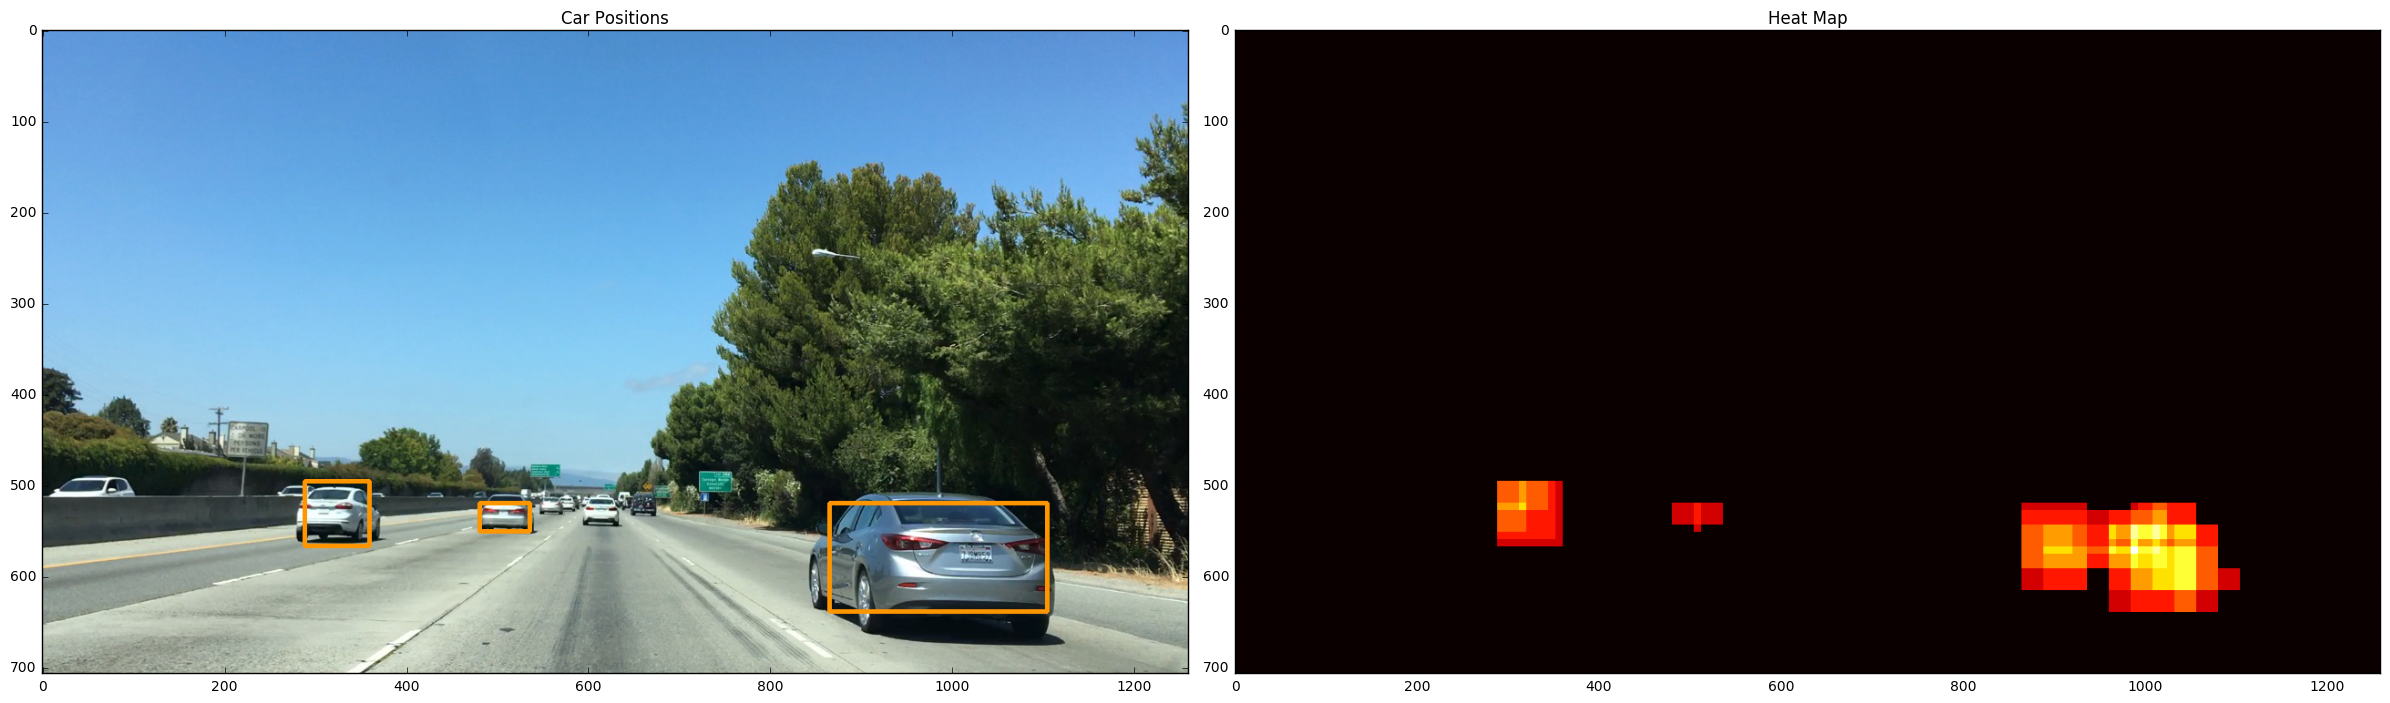

In [116]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,150,0), 4)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize = (24,24))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Block 11 - Pipeline on testing images

In [113]:
from scipy.ndimage.measurements import label

"""
Define a single function that can extract features using hog sub-sampling and make predictions
"""
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              hist_range=(0,256), windows_size=(64,64)):
    
    #Normalize features
    img = img.astype(np.float32)/255.
    # Take region of interest
    img_tosearch = img[ystart:ystop,:,:]
    # Change color space if required
    if color_space != 'BGR':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    else: ctrans_tosearch = np.copy(image)      
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], windows_size)
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append( ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)) )
                
    return boxes


"""
Find the "hot" box for the car
"""
def find_car_box(image, hot_windows, threshold):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    return draw_img

In [141]:
"""
Pipeline

1 - Find hot windows
2 - Find heat map 
3 - Draw image
"""

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0.0,1.0) #Normalize range
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
gamma_correction = False
threshold = 2 #Hot windows threshold
ystart = 400
ystop = 680
scale = 1.5


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    t = time.time()
    boxes_near = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,
              hist_range, windows_size=(96,96))
    """
    boxes_mid = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,
              hist_range, windows_size=(64,64))
    """
    boxes_far = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,
              hist_range, windows_size=(32,32))

    hot_windows = []
    hot_windows.extend(boxes_near)
    #hot_windows.extend(boxes_mid)
    hot_windows.extend(boxes_far)
    
    return cv2.cvtColor(find_car_box(image, hot_windows, threshold), cv2.COLOR_BGR2RGB)

(<matplotlib.axes._subplots.AxesSubplot at 0x1ca24bf5a58>,
 <matplotlib.text.Text at 0x1ca19bbffd0>)

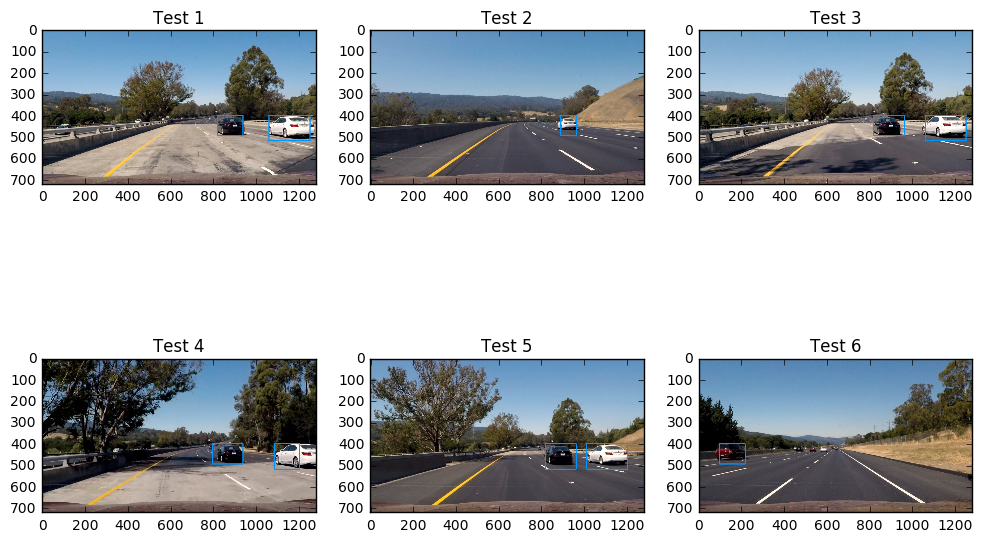

In [139]:
images = glob.glob('test_images/test*.jpg')
draws = []
for image in images:
    image = cv2.imread(image)     
    draws.append(process_image(image))


fig = plt.figure(figsize=(12, 12))
fig.add_subplot(3, 3, 1), plt.imshow(draws[0]), plt.title('Test 1')
fig.add_subplot(3, 3, 2), plt.imshow(draws[1]), plt.title('Test 2')
fig.add_subplot(3, 3, 3), plt.imshow(draws[2]), plt.title('Test 3')
fig.add_subplot(3, 3, 4), plt.imshow(draws[3]), plt.title('Test 4')
fig.add_subplot(3, 3, 5), plt.imshow(draws[4]), plt.title('Test 5')
fig.add_subplot(3, 3, 6), plt.imshow(draws[5]), plt.title('Test 6')

# Block 12 - Run pipeline on the video

In [142]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'senza_mid_vehicle_tracking_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video senza_mid_vehicle_tracking_video.mp4
[MoviePy] Writing video senza_mid_vehicle_tracking_video.mp4


100%|█████████▉| 1260/1261 [12:54<00:00,  1.64it/s]    | 1/1261 [00:00<12:31,  1.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: senza_mid_vehicle_tracking_video.mp4 

Wall time: 12min 55s


In [143]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Thanks for reading
# Diego Paladini